# Temporal Segmentation Test Script

## Setup and Data Pre-Processing
- We need the data to be a series of images at set time steps so if we are passing in a video file or something like that, we need to convert it to a set of discrete images for SAM

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [2]:
def show_anns_reg(anns):
    if len(anns) == 0:
        return
    # sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((anns[0]['segmentation'].shape[0], anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [3]:
# make a list of colors
def random_colors(N):
    np.random.seed(1)
    color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    colors = np.array([color])
    for i in range(N-1):
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
        colors = np.concatenate([colors, [color]], axis=0)
    return colors

color_list = random_colors(100)

def show_mask(mask, ax, random_color=False, color=None):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    elif color is not None:
        color = color
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [59]:
# get matching masks to previous frame and keep matching segmentations based on IOU using Hungarian algorithm
def get_matching_masks(prev_masks, curr_masks, iou_thresh=0.1):
    n_prev_masks = len(prev_masks)
    n_curr_masks = len(curr_masks)
    
    # if there are no masks in the previous frame, then return all the masks in the current frame
    if n_prev_masks == 0:
        return list(range(n_curr_masks))
    
    # if there are no masks in the current frame, then return an empty list
    if n_curr_masks == 0:
        return []
    
    # calculate IOU between all pairs of masks
    iou_matrix = np.zeros((n_prev_masks, n_curr_masks))
    for i in range(n_prev_masks):
        for j in range(n_curr_masks):
            iou_matrix[i][j] = iou(prev_masks[i], curr_masks[j])
    
    # use the Hungarian algorithm to get the best matching pairs of masks
    from scipy.optimize import linear_sum_assignment
    row_ind, col_ind = linear_sum_assignment(-iou_matrix)
    
    # get the matching pairs of masks
    matching_pairs = []
    for i in range(len(row_ind)):
        # if iou_matrix[row_ind[i]][col_ind[i]] > iou_thresh:
        matching_pairs.append((row_ind[i], col_ind[i]))
    
    return matching_pairs

# calculate the intersection over union (IOU) of two masks
def iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    return np.sum(intersection) / np.sum(union)

In [96]:
def find_centroid(mask):
    mask = mask.astype(np.uint8)
    M = cv2.moments(mask)
    if M["m00"] == 0:
        return np.array([0, 0])
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return np.array([cX, cY])

In [4]:
image_dir = '/home/yashas/Documents/thesis/segment-anything/test-images/traj0/images0/'
image_prefix = 'im_'
image_suffix = '.jpg'

In [5]:
big_plot_dim = 8

In [6]:
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

large_sam_checkpoint = "/home/yashas/Documents/thesis/segment-anything/sam_vit_h_4b8939.pth"
large_model_type = "vit_h"

# small_sam_checkpoint = "/home/yashas/Documents/thesis/segment-anything/sam_vit_b_01ec64.pth"
# small_model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[large_model_type](checkpoint=large_sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

## First image visualization and segmentation

In [7]:
image = cv2.imread(image_dir + image_prefix + '0' + image_suffix)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

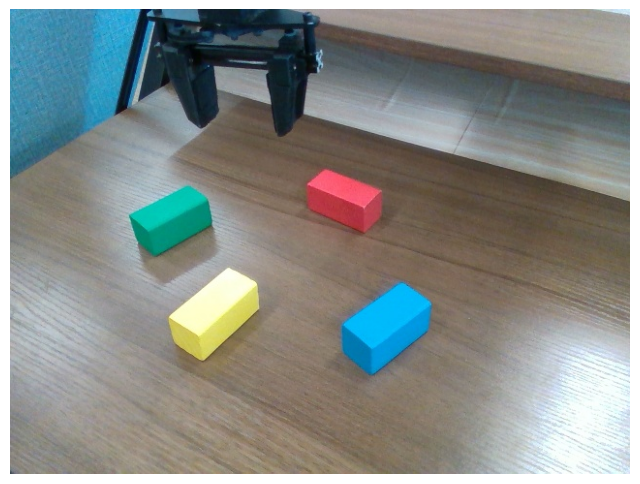

In [8]:
plt.figure(figsize=(big_plot_dim, big_plot_dim))
plt.imshow(image)
plt.axis('off')
plt.show()

In [9]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=16,
    pred_iou_thresh=0.95,
    stability_score_thresh=0.95,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,
    box_nms_thresh=0.1,
)

In [10]:
first_masks = mask_generator.generate(image)
len(first_masks)

12

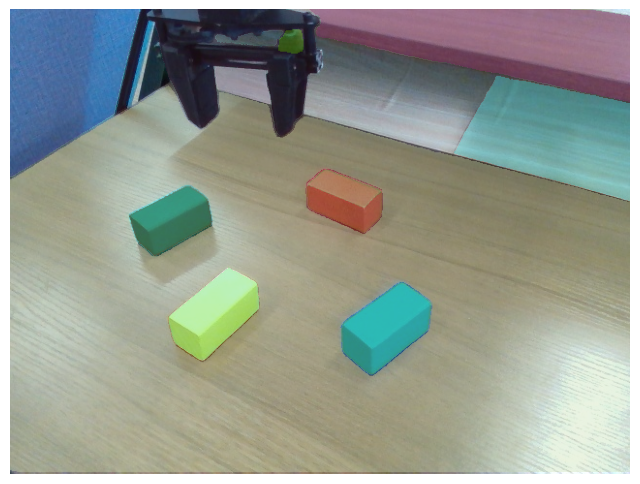

In [11]:
plt.figure(figsize=(big_plot_dim, big_plot_dim))
plt.imshow(image)
show_anns(first_masks)
plt.axis('off')
plt.show()

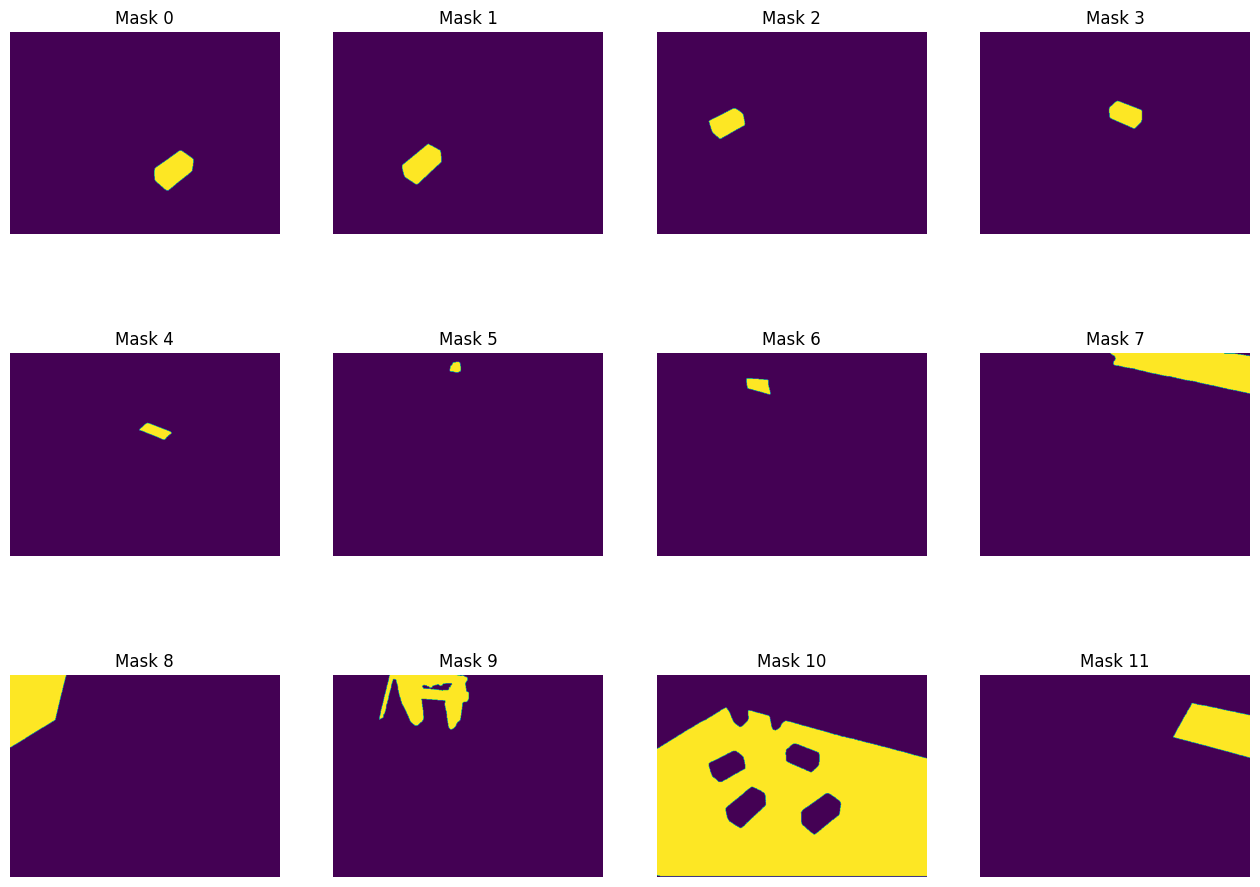

In [12]:
# Visualize each segmentation mask individually in a grid
n = len(first_masks)
cols = 4
rows = n // cols + 1
plt.figure(figsize=(16, 16))
for i, ann in enumerate(first_masks):
    plt.subplot(rows, cols, i + 1)
    plt.title(f"Mask {i}")
    plt.imshow(ann['segmentation'])
    plt.axis('off')

In [13]:
# Give in an array of mask numbers, combine all the masks and return the combined mask
def combine_masks(mask_nums, masks):
    combined_mask = np.zeros(masks[0]['segmentation'].shape, dtype=bool)
    for i in mask_nums:
        combined_mask = np.logical_or(combined_mask, masks[i]['segmentation'])
    return combined_mask

In [14]:
# Given an np.array of shape (mask_num, width, height), return the combined mask
def combine_masks_np(masks):
    combined_mask = np.zeros(masks[0].shape, dtype=bool)
    for mask in masks:
        combined_mask = np.logical_or(combined_mask, mask)
    return combined_mask

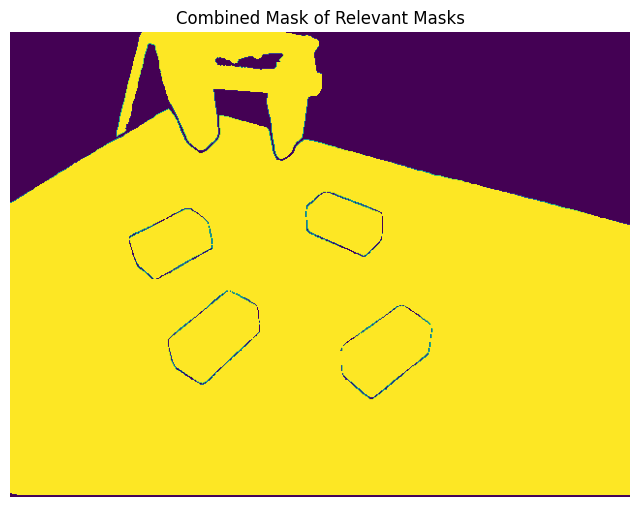

In [15]:
# Combine the masks and display the combined mask
relevant_masks = [0, 1, 2, 3, 10, 9]
relevant_first_mask_anns = [first_masks[i] for i in relevant_masks]
combined_mask = combine_masks(relevant_masks, first_masks)
plt.figure(figsize=(big_plot_dim, big_plot_dim))
plt.imshow(combined_mask)
plt.title("Combined Mask of Relevant Masks")
plt.axis('off')
plt.show()

In [87]:
total_masks_over_time = np.array([[relevant_first_mask_anns[i]['segmentation'] for i in range(len(relevant_first_mask_anns))]])
# the shape of this is [frame_num, mask_num, height, width]
print(total_masks_over_time.shape)

(1, 6, 480, 640)


## Segmentations over time of the rest of the images

In [17]:
# figure out how many images there are in the directory
import os

image_files = os.listdir(image_dir)
image_files = [f for f in image_files if f.endswith('.jpg')]
image_files = sorted(image_files)
n_images = len(image_files)
print(f"Found {n_images} images in the directory")

Found 47 images in the directory


In [22]:
# function to get the bounding box given a mask, not using openCV
def get_box(segmentation_mask):
    rows = len(segmentation_mask)
    if rows == 0:
        return None
    cols = len(segmentation_mask[0])
    
    # Initialize bounding box coordinates
    min_row, min_col = rows, cols
    max_row, max_col = 0, 0
    
    # Iterate through the segmentation mask to find True values
    for row in range(rows):
        for col in range(cols):
            if segmentation_mask[row][col]:
                min_row = min(min_row, row)
                min_col = min(min_col, col)
                max_row = max(max_row, row)
                max_col = max(max_col, col)
    
    # If no True values found, return None
    if min_row == rows or min_col == cols:
        return None
    
    return [min_col, min_row, max_col, max_row]

In [29]:
box_margin = 0.2

frame_num = 1
image = cv2.imread(image_dir + image_prefix + str(frame_num) + image_suffix)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)

# get bounding boxes from previous masks
boxes = [get_box(mask) for mask in total_masks_over_time[frame_num-1]]
print(boxes)
# inflate boxes
for box in boxes:
    if box is not None:
        box[0] = max(0, box[0] - box_margin * (box[2] - box[0]))
        box[1] = max(0, box[1] - box_margin * (box[3] - box[1]))
        box[2] = min(image.shape[1], box[2] + box_margin * (box[2] - box[0]))
        box[3] = min(image.shape[0], box[3] + box_margin * (box[3] - box[1]))

input_boxes = torch.tensor(boxes, device=predictor.device)

transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])

[[342, 282, 434, 376], [164, 267, 256, 362], [123, 183, 208, 254], [306, 165, 383, 230], [0, 79, 639, 477], [110, 0, 321, 130]]


In [56]:
masks, scores, logits = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=True,
)

In [57]:
print(masks.shape)
masks = masks.cpu().numpy()

torch.Size([6, 3, 480, 640])


(3, 480, 640)
(480, 640)
(3, 480, 640)
(480, 640)
(3, 480, 640)
(480, 640)
(3, 480, 640)
(480, 640)
(3, 480, 640)
(480, 640)
(3, 480, 640)
(480, 640)


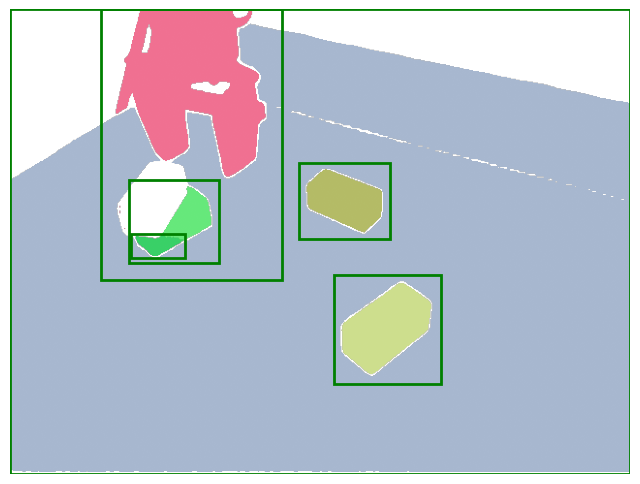

In [95]:
plt.figure(figsize=(big_plot_dim, big_plot_dim))
# plt.imshow(image)
for mask in masks:
    print(mask.shape)
    # get first element of mask but keep shape of mask
    mask = mask[1]
    print(mask.shape)
    show_mask(mask, plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

In [82]:
# flatten all multimasks into one masks array
# create curr_frame_all_masks as numpy array with dimensions n_masks, height, width
curr_frame_all_masks = np.array([masks[i][j] for i in range(masks.shape[0]) for j in range(masks.shape[1])])
print(masks.shape)
print(curr_frame_all_masks.shape)
# compute matching pairs between masks and total_masks_over_time[frame_num]
matching_pairs = get_matching_masks(total_masks_over_time[frame_num-1], curr_frame_all_masks)
print(matching_pairs)
matching_masks = [curr_frame_all_masks[pair[1]] for pair in matching_pairs]
total_masks_over_time = np.append(total_masks_over_time, np.array([matching_masks]), axis=0)
print(total_masks_over_time.shape)

(6, 3, 480, 640)
(18, 480, 640)
[(0, 2), (1, 4), (2, 6), (3, 10), (4, 12), (5, 16)]
(7, 6, 480, 640)


(1, 6, 480, 640)
Frame Number:  1
[[342, 282, 434, 376], [164, 267, 256, 362], [123, 183, 208, 254], [306, 165, 383, 230], [0, 79, 639, 477], [110, 0, 321, 130]]


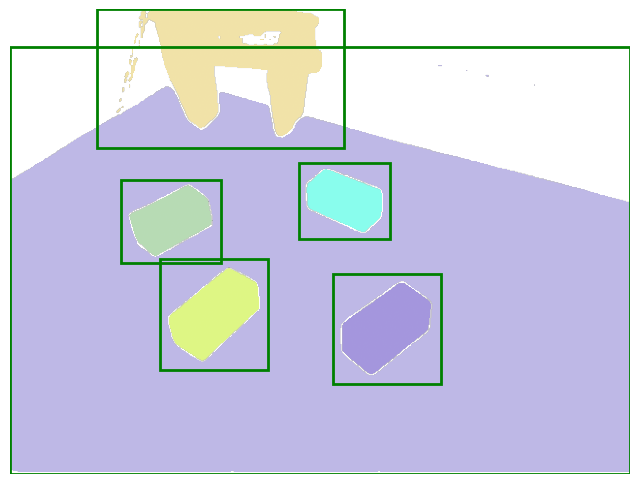

(2, 6, 480, 640)
Frame Number:  2
[[342, 282, 434, 376], [164, 267, 256, 362], [123, 182, 208, 254], [306, 165, 383, 229], [0, 58, 639, 477], [110, 0, 321, 130]]


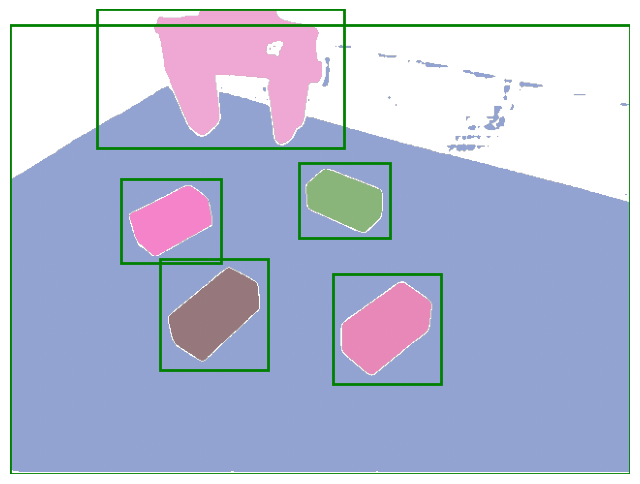

(3, 6, 480, 640)
Frame Number:  3
[[342, 282, 434, 376], [164, 267, 256, 362], [124, 183, 207, 254], [306, 165, 383, 229], [0, 81, 639, 477], [110, 0, 322, 138]]


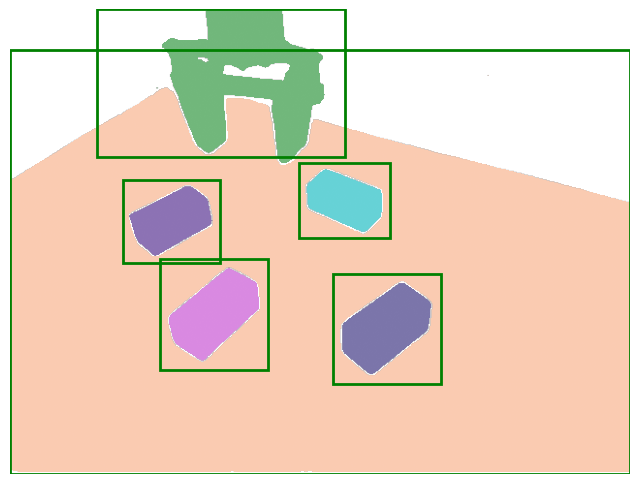

(4, 6, 480, 640)
Frame Number:  4
[[342, 282, 434, 376], [164, 267, 256, 362], [123, 183, 208, 254], [306, 165, 383, 229], [0, 68, 639, 477], [109, 0, 324, 158]]


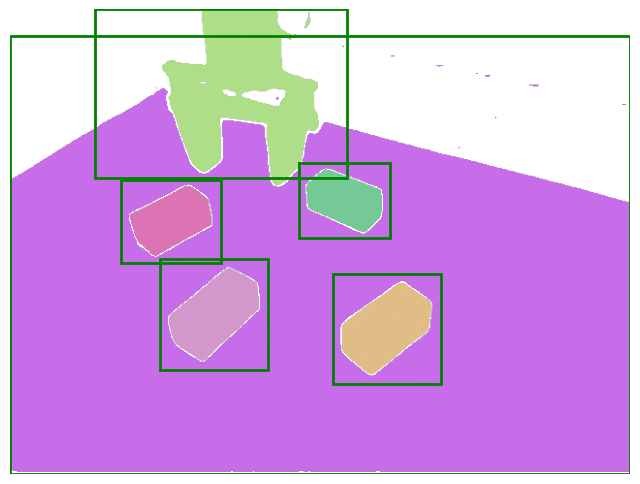

(5, 6, 480, 640)
Frame Number:  5
[[343, 282, 434, 376], [164, 267, 256, 362], [123, 183, 207, 254], [306, 165, 383, 229], [0, 38, 639, 477], [110, 0, 318, 181]]


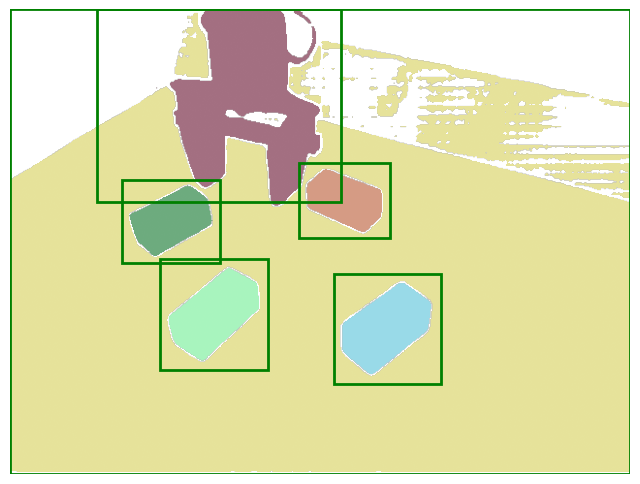

(6, 6, 480, 640)
Frame Number:  6
[[343, 282, 434, 376], [164, 267, 256, 362], [123, 182, 208, 254], [306, 165, 383, 229], [0, 38, 639, 477], [110, 0, 320, 202]]


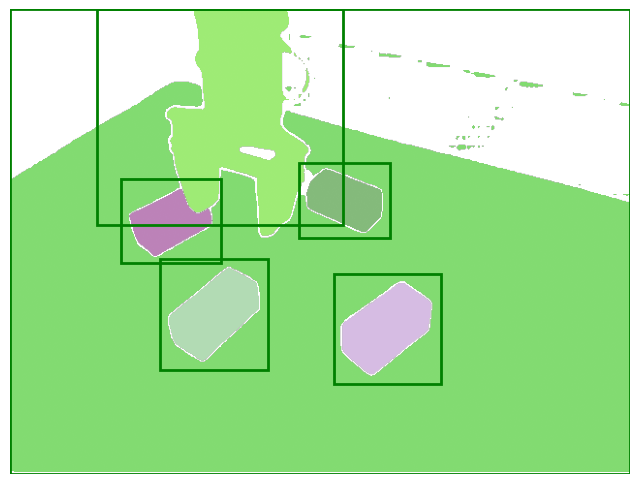

(7, 6, 480, 640)
Frame Number:  7
[[342, 282, 434, 376], [164, 267, 256, 362], [123, 186, 208, 254], [306, 165, 383, 229], [0, 48, 639, 477], [162, 0, 308, 233]]


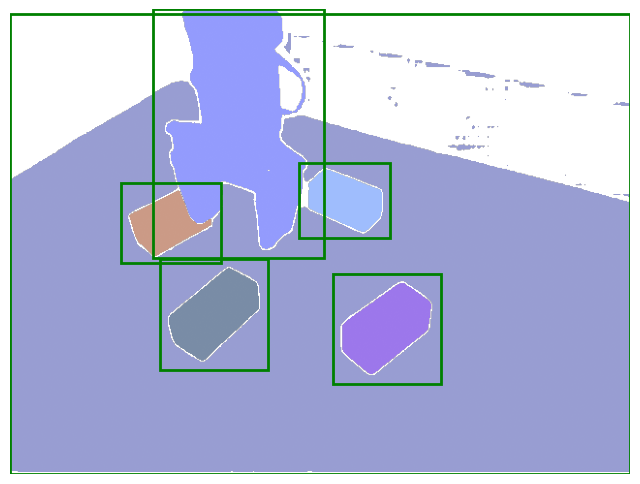

(8, 6, 480, 640)
Frame Number:  8
[[342, 283, 434, 376], [164, 267, 256, 362], [123, 187, 211, 254], [306, 165, 383, 229], [0, 26, 639, 477], [162, 0, 304, 246]]


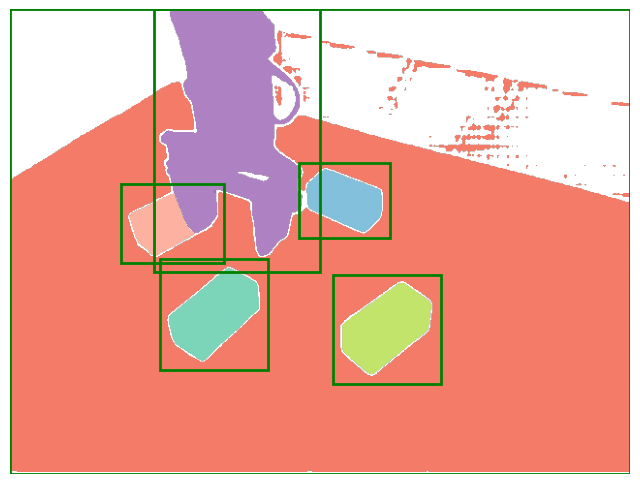

(9, 6, 480, 640)
Frame Number:  9
[[342, 283, 434, 376], [164, 267, 256, 362], [123, 187, 213, 254], [306, 165, 383, 229], [0, 23, 639, 477], [156, 0, 300, 254]]


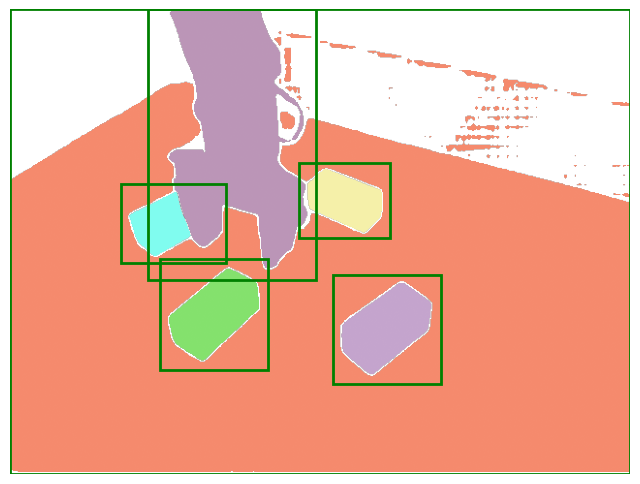

(10, 6, 480, 640)
Frame Number:  10
[[342, 283, 434, 376], [164, 268, 256, 362], [123, 189, 186, 254], [307, 165, 383, 230], [0, 28, 639, 477], [164, 0, 306, 267]]


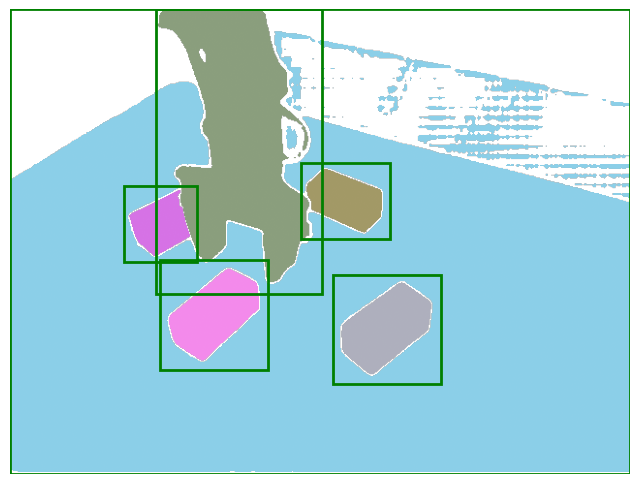

(11, 6, 480, 640)
Frame Number:  11
[[342, 282, 434, 376], [164, 268, 256, 362], [123, 187, 185, 254], [306, 165, 383, 230], [0, 28, 639, 477], [155, 0, 308, 281]]


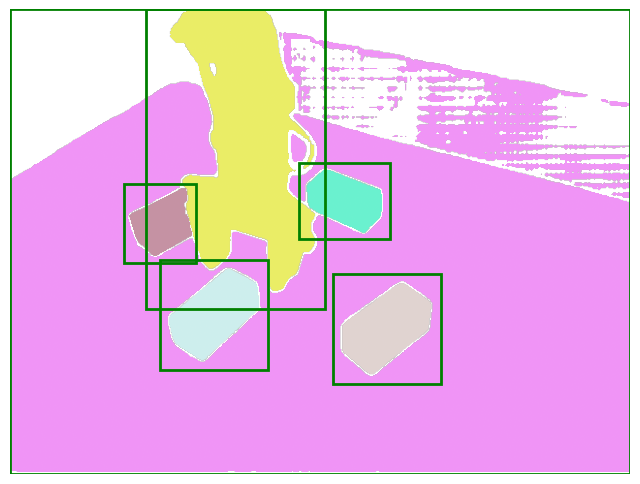

(12, 6, 480, 640)
Frame Number:  12
[[343, 283, 434, 376], [164, 268, 256, 362], [123, 185, 187, 254], [306, 165, 383, 230], [0, 28, 639, 477], [165, 0, 314, 290]]


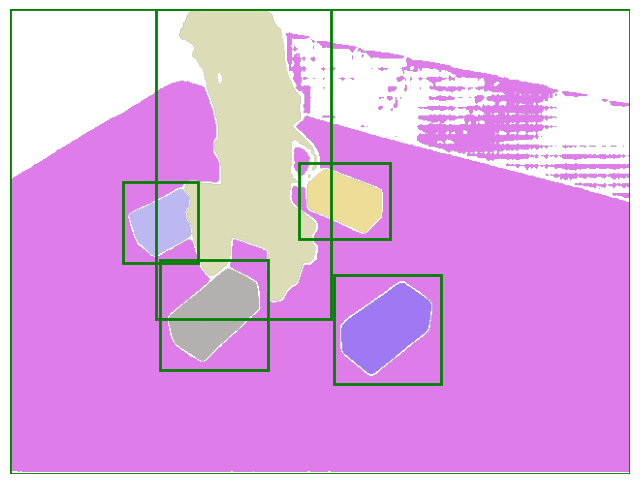

(13, 6, 480, 640)
Frame Number:  13
[[342, 283, 434, 376], [164, 268, 256, 362], [123, 186, 187, 254], [306, 165, 383, 230], [0, 26, 639, 477], [175, 0, 316, 300]]


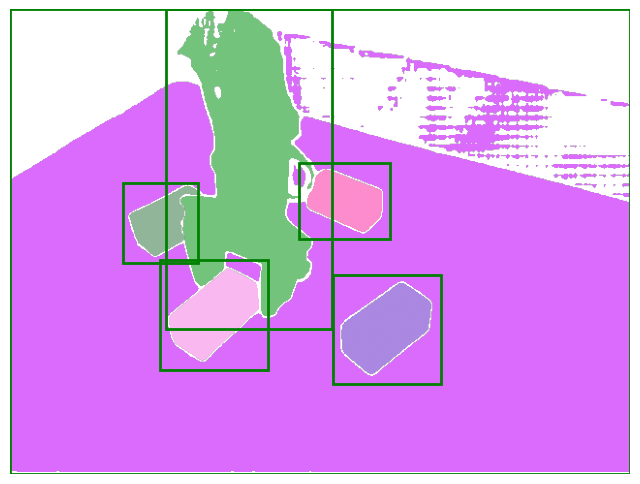

(14, 6, 480, 640)
Frame Number:  14
[[343, 283, 434, 376], [164, 268, 256, 362], [123, 182, 196, 254], [307, 165, 383, 229], [0, 28, 639, 477], [168, 0, 313, 316]]


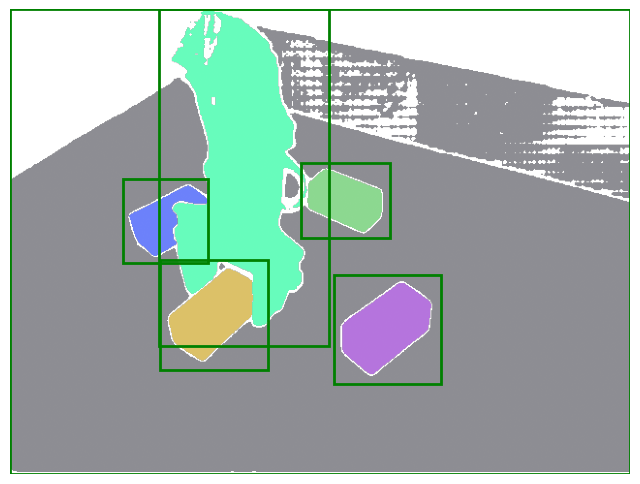

(15, 6, 480, 640)
Frame Number:  15
[[343, 283, 434, 376], [164, 268, 250, 362], [123, 182, 203, 254], [307, 165, 383, 229], [0, 23, 639, 477], [165, 0, 306, 326]]


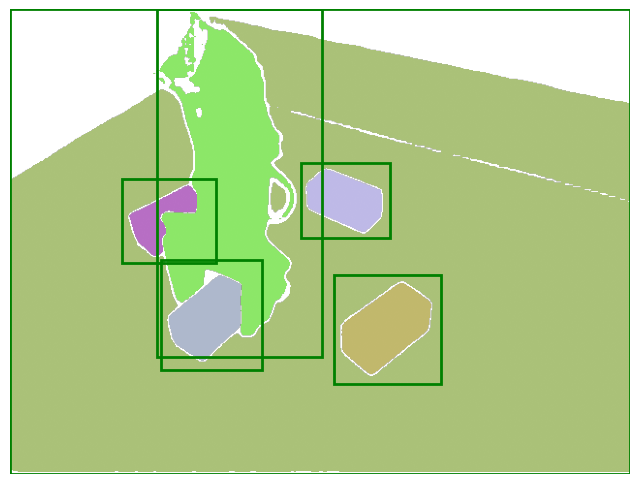

(16, 6, 480, 640)
Frame Number:  16
[[343, 283, 434, 376], [164, 275, 238, 362], [123, 182, 192, 254], [306, 165, 383, 229], [0, 18, 639, 477], [148, 3, 292, 336]]


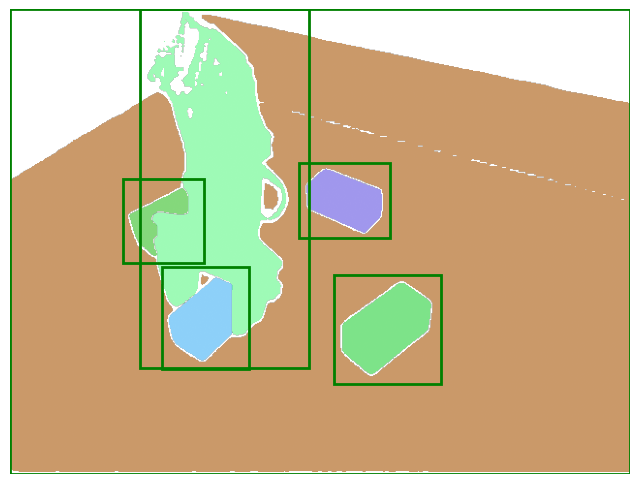

(17, 6, 480, 640)
Frame Number:  17
[[343, 283, 434, 376], [164, 277, 229, 362], [123, 185, 183, 254], [306, 165, 383, 230], [0, 18, 639, 477], [142, 3, 284, 336]]


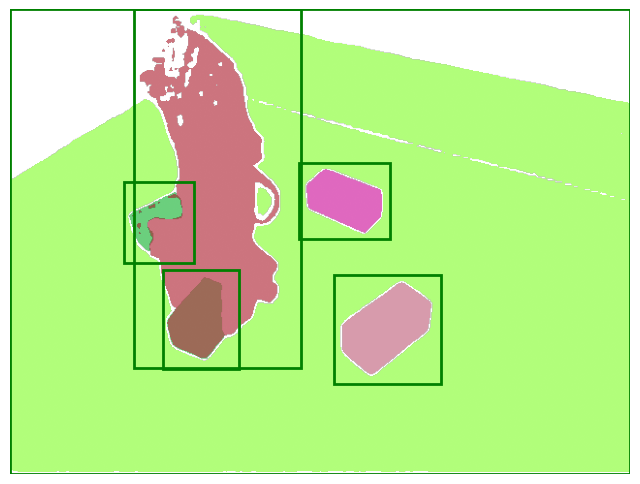

(18, 6, 480, 640)
Frame Number:  18
[[343, 283, 434, 376], [162, 277, 221, 360], [123, 189, 177, 249], [306, 165, 383, 230], [0, 18, 639, 477], [126, 7, 277, 359]]


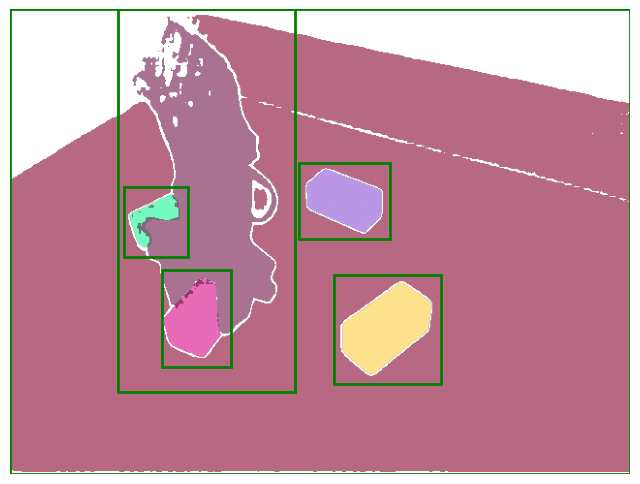

(19, 6, 480, 640)
Frame Number:  19
[[343, 283, 434, 376], [158, 271, 217, 358], [123, 191, 174, 245], [306, 165, 383, 230], [0, 21, 639, 477], [116, 3, 274, 357]]


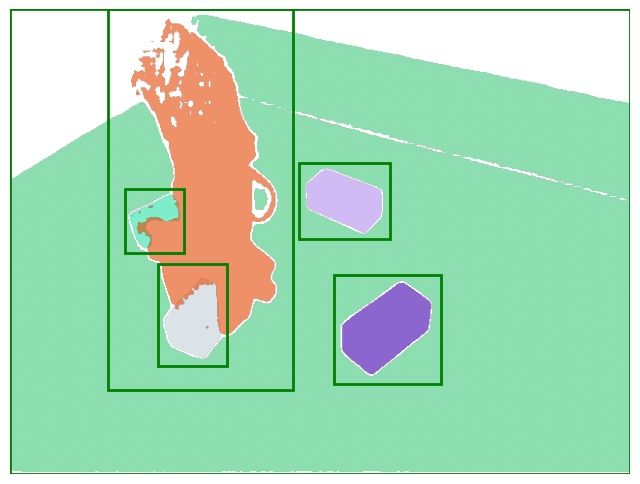

(20, 6, 480, 640)
Frame Number:  20
[[343, 283, 434, 376], [158, 271, 217, 359], [123, 191, 174, 246], [306, 165, 383, 230], [0, 21, 639, 477], [95, 0, 274, 358]]


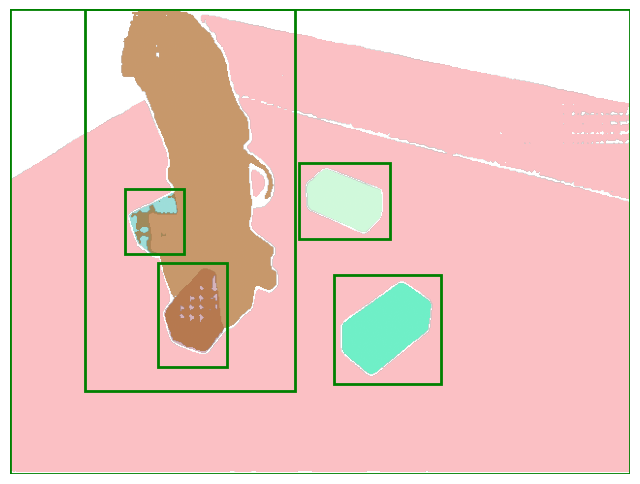

(21, 6, 480, 640)
Frame Number:  21
[[343, 283, 434, 376], [159, 268, 220, 354], [123, 190, 172, 253], [306, 165, 383, 229], [0, 20, 639, 477], [115, 0, 274, 352]]


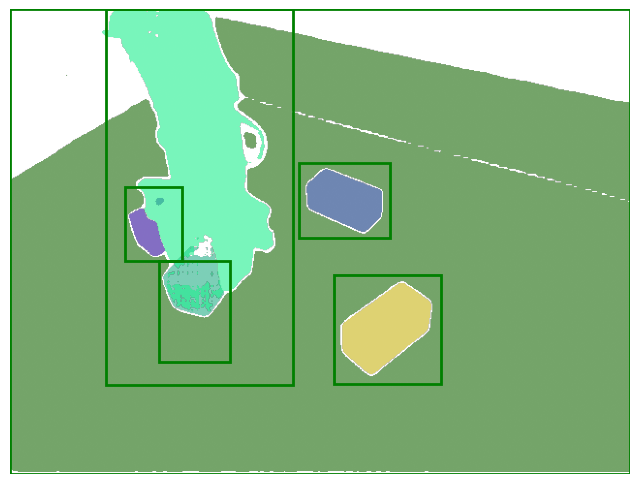

(22, 6, 480, 640)
Frame Number:  22
[[343, 283, 434, 376], [159, 266, 220, 316], [123, 178, 166, 261], [306, 165, 383, 229], [0, 18, 639, 477], [91, 0, 271, 315]]


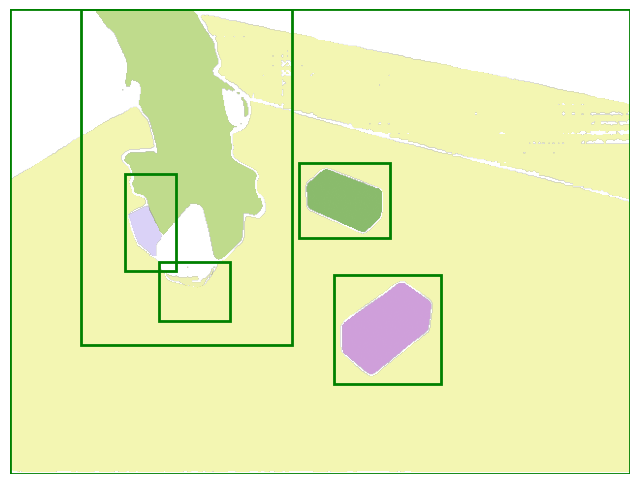

(23, 6, 480, 640)
Frame Number:  23
[[343, 283, 434, 376], [161, 266, 211, 287], [123, 203, 156, 254], [306, 165, 383, 229], [0, 8, 639, 477], [90, 0, 261, 283]]


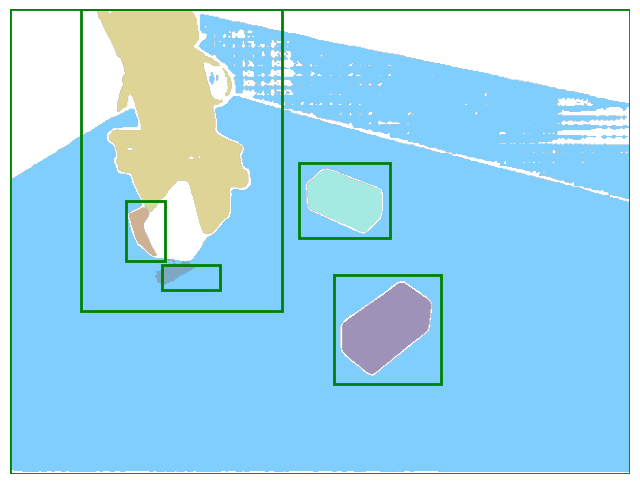

(24, 6, 480, 640)
Frame Number:  24
[[343, 283, 434, 376], [153, 266, 193, 285], [123, 205, 151, 254], [306, 165, 383, 229], [0, 8, 639, 477], [90, 0, 246, 257]]


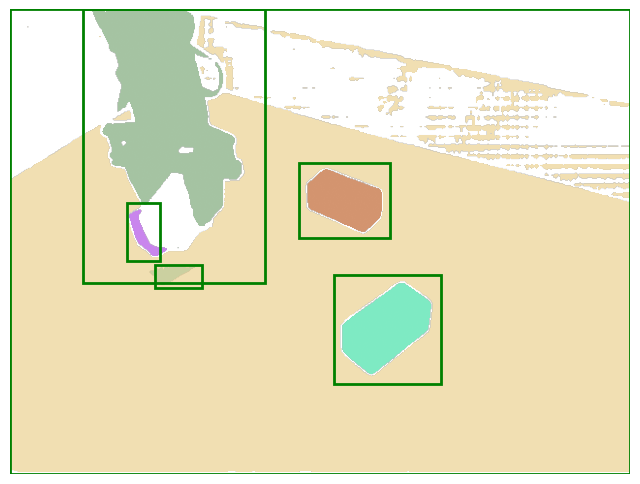

(25, 6, 480, 640)
Frame Number:  25
[[343, 283, 434, 376], [150, 269, 183, 285], [123, 207, 161, 254], [307, 165, 383, 229], [0, 28, 639, 477], [86, 0, 239, 253]]


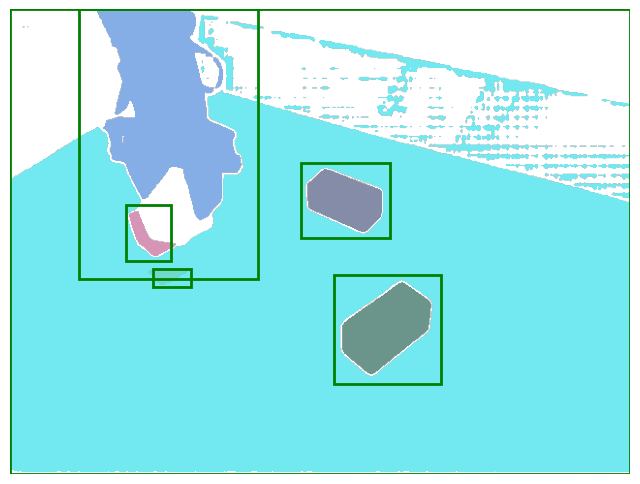

(26, 6, 480, 640)
Frame Number:  26
[[343, 283, 434, 376], [144, 270, 181, 284], [123, 209, 170, 254], [306, 165, 383, 229], [0, 8, 639, 477], [91, 0, 238, 253]]


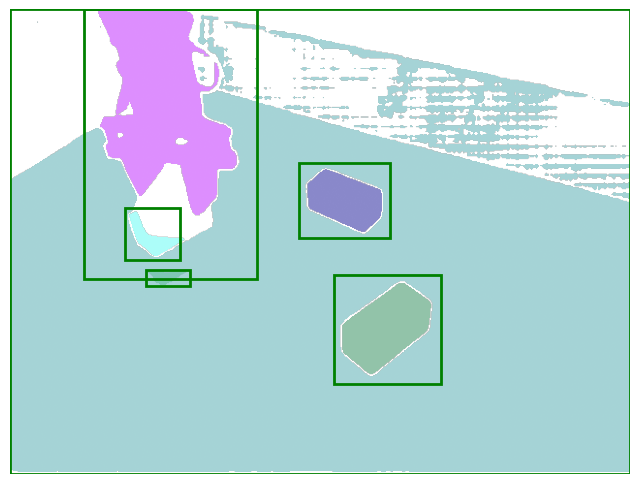

(27, 6, 480, 640)
Frame Number:  27
[[343, 283, 434, 376], [141, 270, 181, 284], [123, 209, 177, 254], [307, 165, 383, 230], [0, 28, 639, 477], [91, 0, 233, 253]]


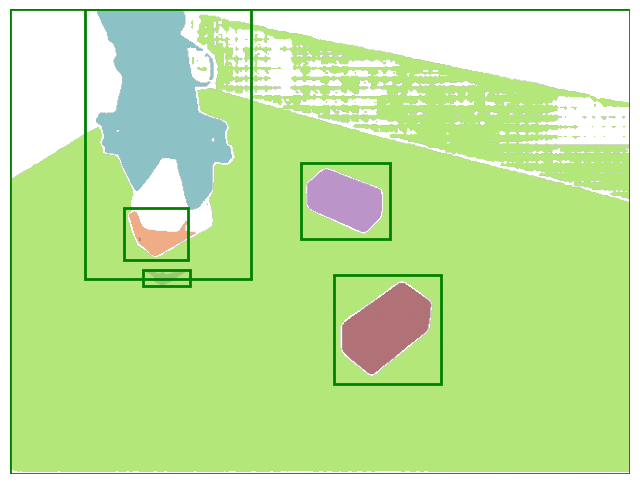

(28, 6, 480, 640)
Frame Number:  28
[[343, 283, 434, 376], [140, 270, 183, 285], [123, 209, 181, 254], [307, 165, 383, 230], [0, 28, 639, 477], [89, 0, 228, 253]]


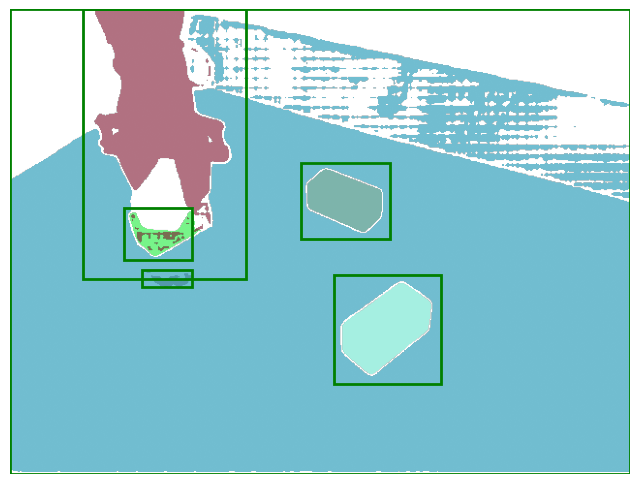

(29, 6, 480, 640)
Frame Number:  29
[[343, 283, 434, 376], [140, 270, 173, 285], [123, 210, 190, 254], [306, 165, 383, 229], [0, 28, 639, 477], [87, 0, 226, 253]]


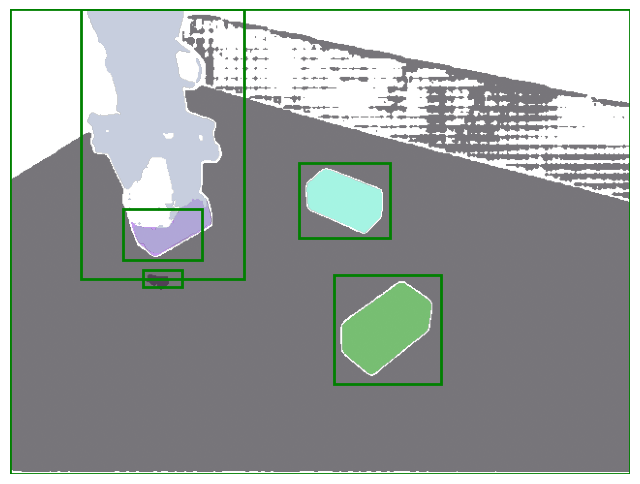

(30, 6, 480, 640)
Frame Number:  30
[[343, 283, 434, 376], [138, 267, 171, 289], [125, 204, 207, 254], [306, 165, 383, 230], [0, 28, 639, 477], [80, 0, 216, 253]]


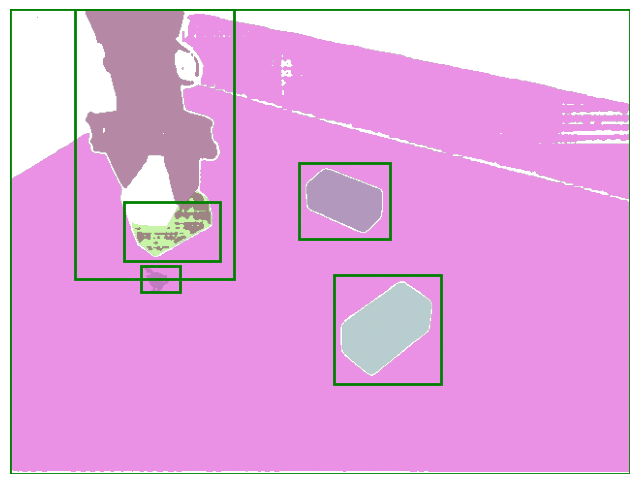

(31, 6, 480, 640)
Frame Number:  31
[[343, 283, 434, 376], [136, 256, 167, 294], [126, 189, 207, 254], [306, 165, 383, 229], [0, 8, 639, 477], [77, 0, 214, 253]]


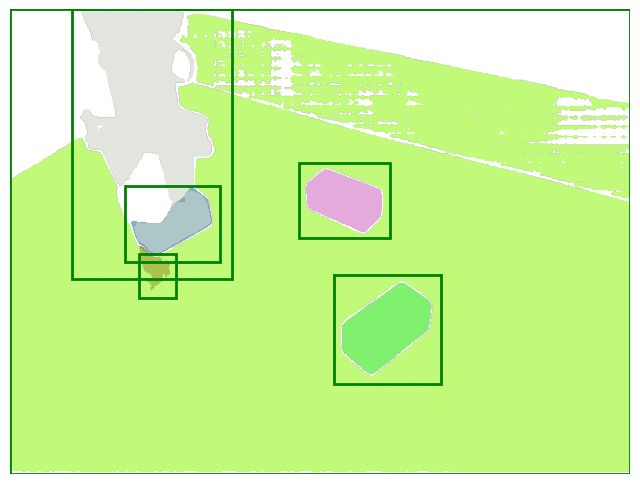

(32, 6, 480, 640)
Frame Number:  32
[[343, 283, 434, 376], [132, 245, 168, 296], [125, 184, 207, 254], [306, 165, 383, 229], [0, 28, 639, 477], [72, 0, 208, 253]]


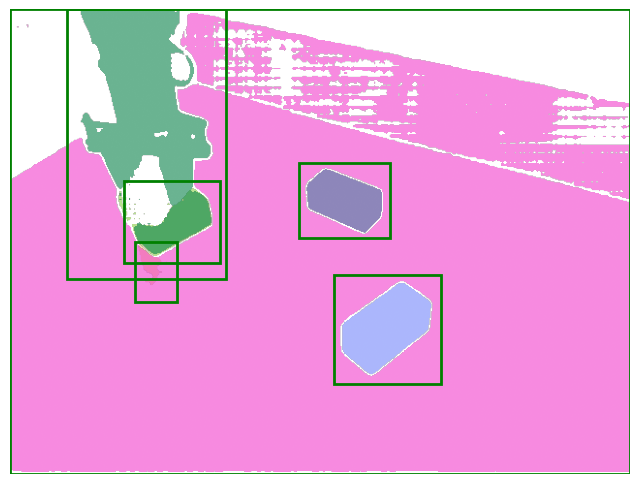

(33, 6, 480, 640)
Frame Number:  33
[[343, 283, 434, 376], [132, 242, 165, 293], [126, 185, 207, 254], [306, 165, 383, 230], [0, 8, 639, 477], [72, 0, 207, 253]]


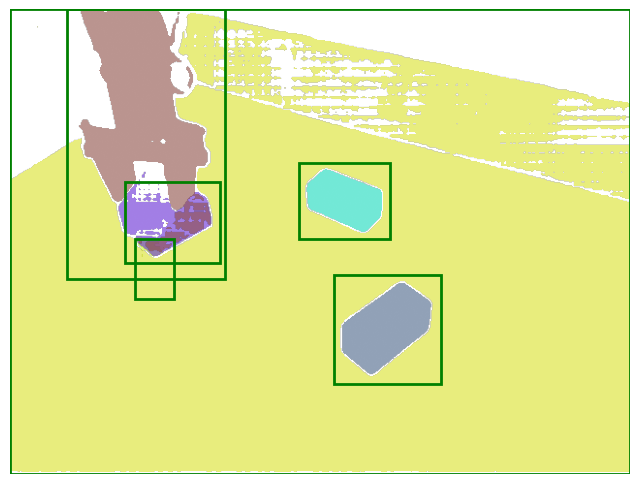

(34, 6, 480, 640)
Frame Number:  34
[[343, 283, 434, 376], [129, 235, 165, 255], [130, 188, 207, 254], [306, 165, 383, 229], [0, 8, 639, 477], [70, 0, 207, 254]]


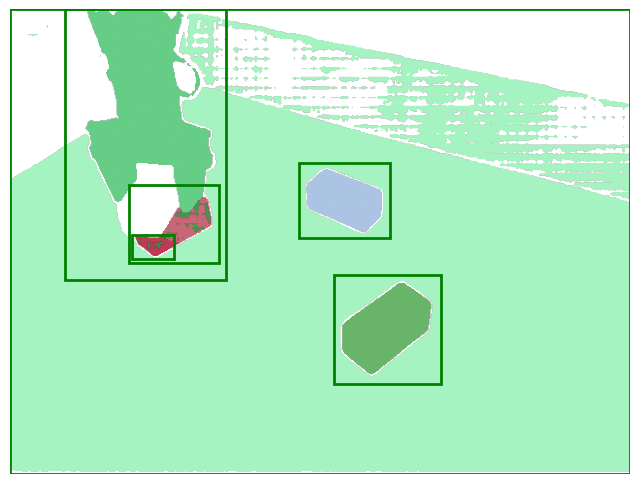

(35, 6, 480, 640)
Frame Number:  35
[[343, 283, 434, 376], [129, 234, 170, 254], [130, 194, 207, 254], [306, 165, 383, 230], [0, 8, 639, 477], [78, 0, 209, 254]]


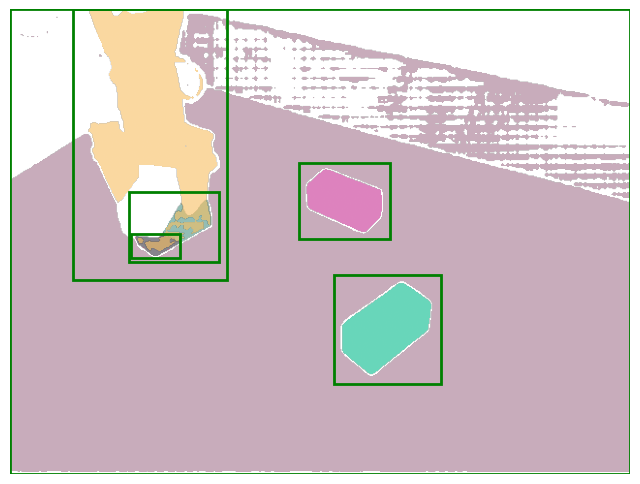

(36, 6, 480, 640)
Frame Number:  36
[[343, 283, 434, 376], [129, 234, 174, 254], [130, 197, 207, 254], [306, 165, 383, 229], [0, 8, 639, 477], [81, 0, 213, 253]]


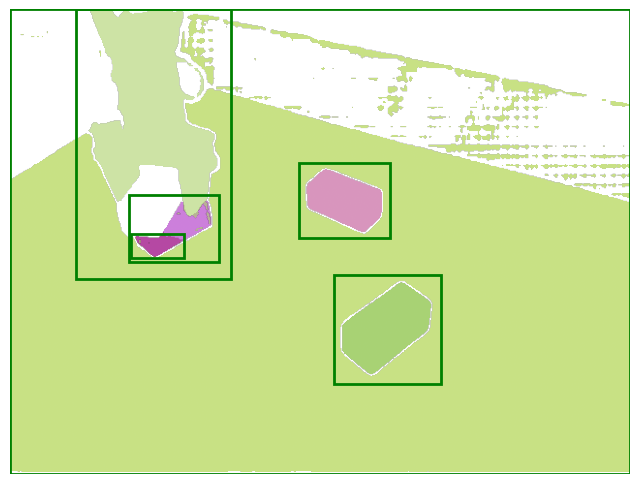

(37, 6, 480, 640)
Frame Number:  37
[[343, 283, 434, 376], [129, 234, 174, 255], [130, 198, 207, 255], [306, 165, 383, 229], [0, 8, 639, 477], [82, 0, 214, 254]]


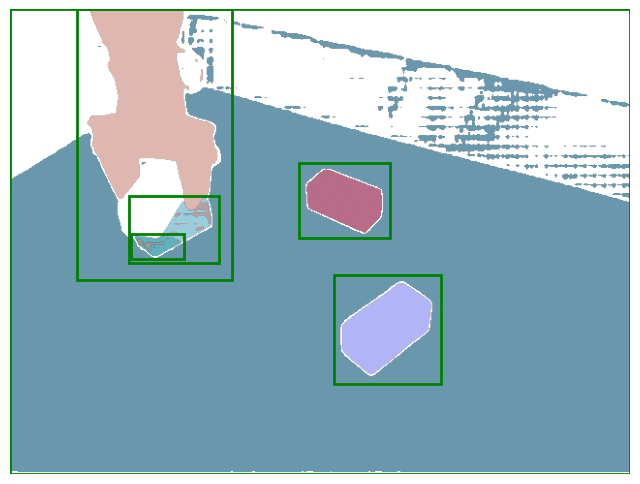

(38, 6, 480, 640)
Frame Number:  38
[[343, 283, 434, 376], [129, 234, 174, 254], [129, 194, 207, 254], [306, 165, 383, 230], [0, 28, 639, 477], [80, 0, 214, 254]]


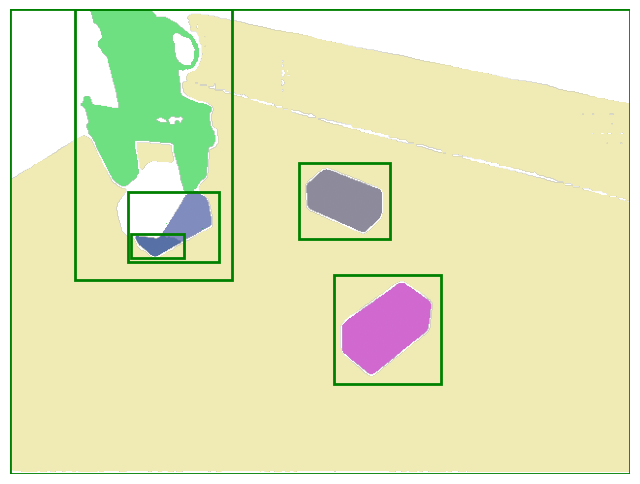

(39, 6, 480, 640)
Frame Number:  39
[[343, 283, 434, 376], [129, 234, 174, 255], [129, 188, 207, 254], [306, 166, 383, 229], [0, 28, 639, 477], [73, 0, 212, 254]]


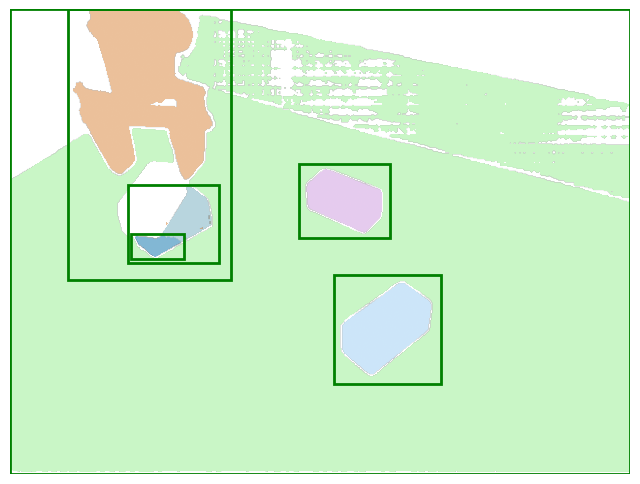

(40, 6, 480, 640)
Frame Number:  40
[[343, 283, 434, 376], [129, 234, 174, 255], [114, 183, 207, 254], [306, 165, 383, 229], [0, 28, 639, 477], [65, 0, 208, 254]]


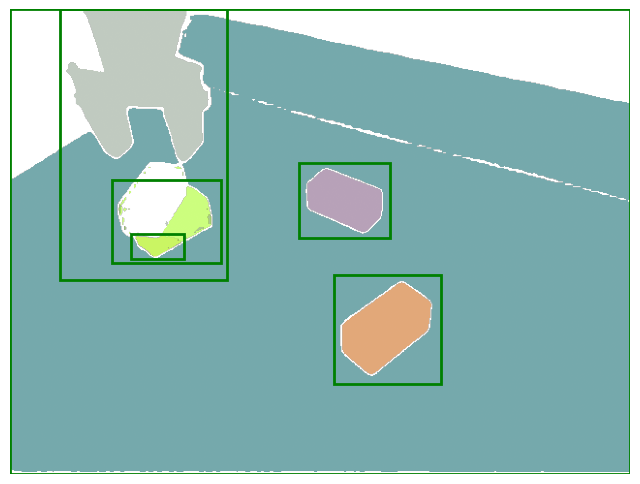

(41, 6, 480, 640)
Frame Number:  41
[[343, 283, 434, 376], [129, 234, 174, 255], [130, 183, 207, 255], [306, 165, 383, 229], [0, 28, 639, 477], [58, 0, 207, 254]]


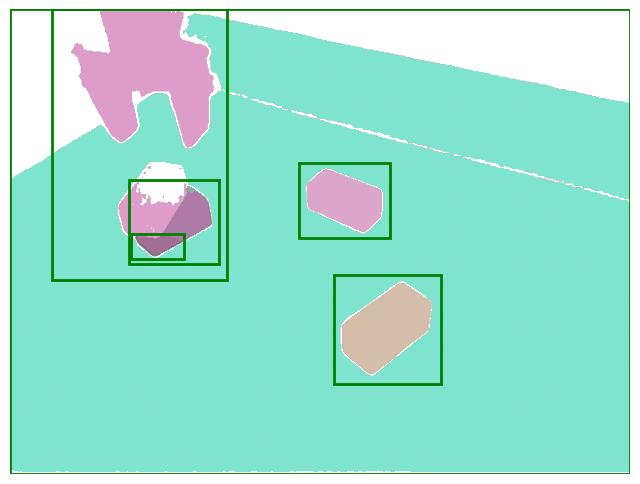

(42, 6, 480, 640)
Frame Number:  42
[[343, 283, 434, 376], [129, 234, 175, 254], [130, 183, 207, 254], [306, 165, 383, 229], [0, 22, 639, 477], [62, 0, 209, 254]]


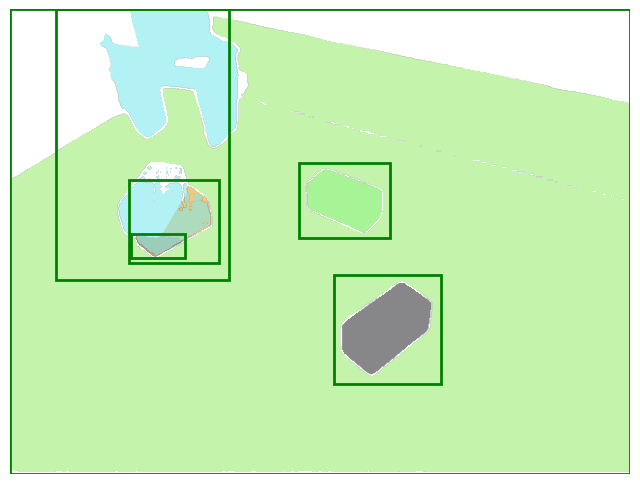

(43, 6, 480, 640)
Frame Number:  43
[[343, 283, 434, 376], [130, 234, 175, 255], [130, 183, 207, 254], [306, 165, 383, 230], [0, 18, 639, 477], [93, 0, 235, 254]]


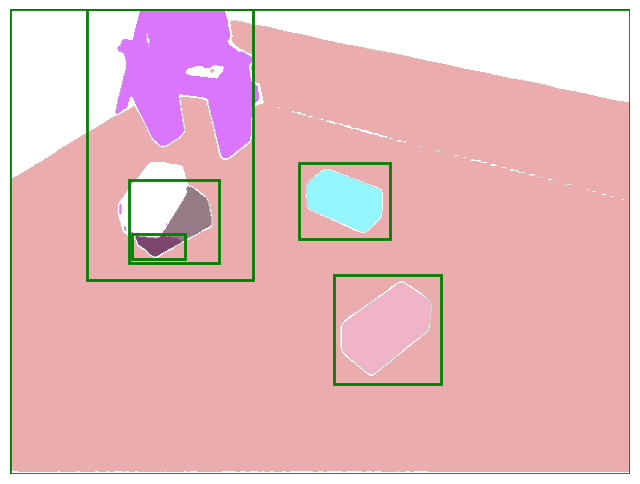

(44, 6, 480, 640)
Frame Number:  44
[[343, 283, 434, 376], [129, 234, 175, 255], [130, 183, 207, 254], [306, 165, 383, 229], [0, 18, 639, 477], [109, 0, 255, 254]]


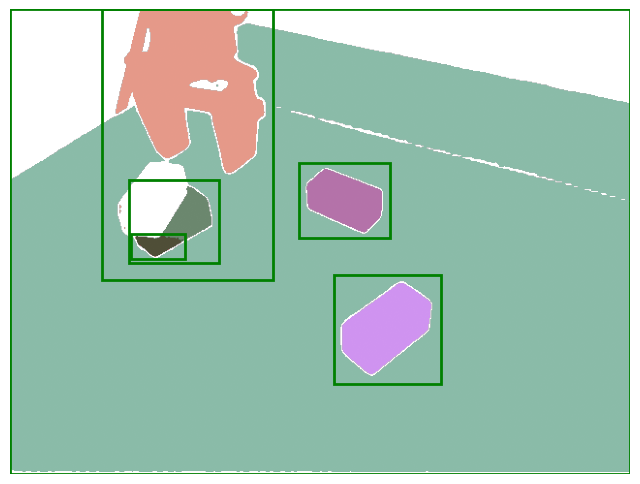

(45, 6, 480, 640)
Frame Number:  45
[[343, 283, 434, 376], [129, 234, 175, 255], [130, 183, 207, 254], [306, 165, 383, 230], [0, 17, 639, 477], [109, 0, 261, 253]]


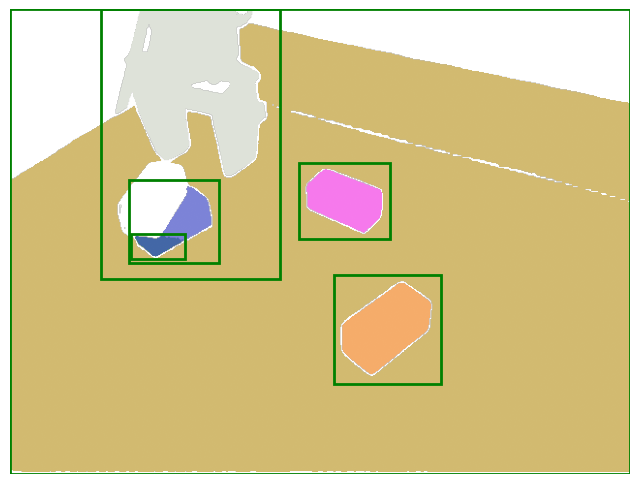

(46, 6, 480, 640)
Frame Number:  46
[[343, 283, 434, 376], [129, 234, 175, 254], [130, 183, 207, 254], [306, 165, 383, 230], [0, 17, 639, 477], [109, 0, 263, 254]]


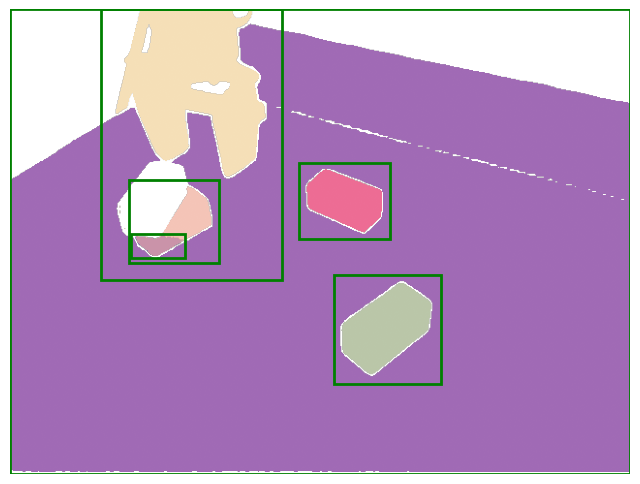

(47, 6, 480, 640)


In [90]:
box_margin = 0.1

total_masks_over_time = np.array([[relevant_first_mask_anns[i]['segmentation'] for i in range(len(relevant_first_mask_anns))]])
# the shape of this is [frame_num, mask_num, height, width]
print(total_masks_over_time.shape)
for i in range(1, n_images):
    frame_num = i
    image = cv2.imread(image_dir + image_prefix + str(frame_num) + image_suffix)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image)

    # get bounding boxes from previous masks
    boxes = [get_box(mask) for mask in total_masks_over_time[frame_num-1]]
    print("Frame Number: ", frame_num)
    print(boxes)
    # inflate boxes
    for box in boxes:
        if box is not None:
            box[0] = max(0, box[0] - box_margin * (box[2] - box[0]))
            box[1] = max(0, box[1] - box_margin * (box[3] - box[1]))
            box[2] = min(image.shape[1], box[2] + box_margin * (box[2] - box[0]))
            box[3] = min(image.shape[0], box[3] + box_margin * (box[3] - box[1]))

    input_boxes = torch.tensor(boxes, device=predictor.device)

    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])

    masks, scores, logits = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=True,
    )

    masks = masks.cpu().numpy()

    plt.figure(figsize=(big_plot_dim, big_plot_dim))
    # plt.imshow(image)
    for mask in masks:
        # print(mask.shape)
        # get first element of mask but keep shape of mask
        mask = mask[1]
        # print(mask.shape)
        show_mask(mask, plt.gca(), random_color=True)
    for box in input_boxes:
        show_box(box.cpu().numpy(), plt.gca())
    plt.axis('off')
    plt.show()

    # flatten all multimasks into one masks array
    # create curr_frame_all_masks as numpy array with dimensions n_masks, height, width
    curr_frame_all_masks = np.array([masks[i][j] for i in range(masks.shape[0]) for j in range(masks.shape[1])])
    # compute matching pairs between masks and total_masks_over_time[frame_num]
    matching_pairs = get_matching_masks(total_masks_over_time[frame_num-1], curr_frame_all_masks)
    # print(matching_pairs)
    matching_masks = [curr_frame_all_masks[pair[1]] for pair in matching_pairs]
    total_masks_over_time = np.append(total_masks_over_time, np.array([matching_masks]), axis=0)
    print(total_masks_over_time.shape)

### Old method

In [ ]:
next_image = cv2.imread(image_dir + image_prefix + '1' + image_suffix)
next_image = cv2.cvtColor(next_image, cv2.COLOR_BGR2RGB)
next_masks = mask_generator.generate(next_image)
print(len(next_masks))

In [ ]:
# run mask matching for all images in folder
for i in range(1, n_images):
    # get the masks for the next image
    next_image = cv2.imread(image_dir + image_prefix + str(i) + image_suffix)
    next_image = cv2.cvtColor(next_image, cv2.COLOR_BGR2RGB)
    next_masks = mask_generator.generate(next_image)

    # Visualize each segmentation mask individually in a grid
    n = len(next_masks)
    cols = 4
    rows = n // cols + 1
    plt.figure(figsize=(16, 16))
    for j, ann in enumerate(next_masks):
        plt.subplot(rows, cols, j + 1)
        plt.title(f"Frame {i} Mask {j}")
        plt.imshow(ann['segmentation'])
        plt.axis('off')
    plt.savefig(f"masks_{i}.png")

    # get the matching masks
    matching_pairs = get_matching_masks(total_masks_over_time[i-1], [next_masks[i]['segmentation'] for i in range(len(next_masks))])
    print(matching_pairs)

    # add matching masks from Hungarian algorithm to the total masks over time
    matching_masks = [next_masks[j]['segmentation'] for i, j in matching_pairs]
    total_masks_over_time = np.append(total_masks_over_time, np.array([matching_masks]), axis=0)
    print(total_masks_over_time.shape)

In [ ]:
# Visualize the total_masks_over_time, with each mask in each frame being a different color
n = total_masks_over_time.shape[0]
cols = 4
rows = n // cols + 1
plt.figure(figsize=(16, 16))
for i in range(n):
    plt.subplot(rows, cols, i + 1)
    plt.title(f"Frame {i}")
    for j in range(len(relevant_first_mask_anns)):
        show_mask(total_masks_over_time[i][j], plt.gca(), color=np.array(color_list[j]))
    plt.axis('off')


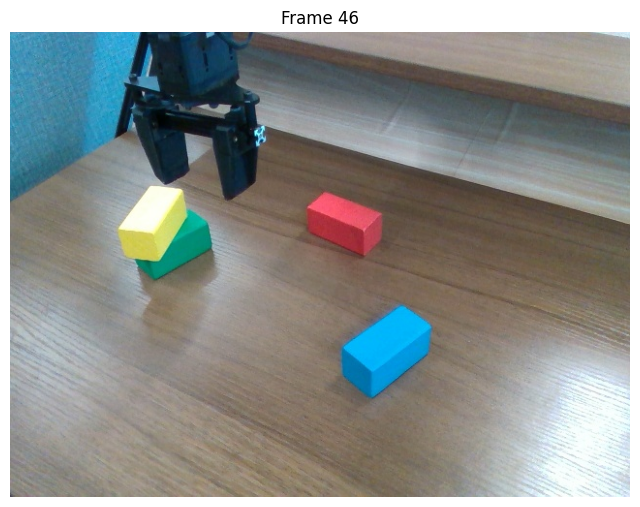

In [92]:
# Visualize all images in directory as animation
import time
from IPython.display import display, clear_output

for i in range(0, n_images):
    image = cv2.imread(image_dir + image_prefix + str(i) + image_suffix)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(big_plot_dim, big_plot_dim))
    plt.title(f"Frame {i}")
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)

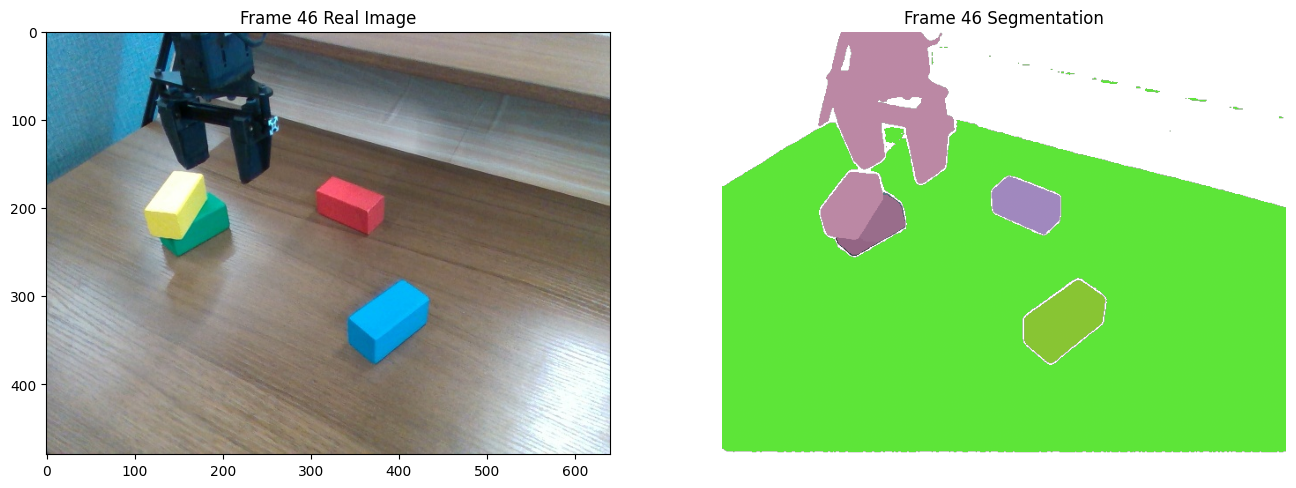

In [94]:
# Visualize the total_masks_over_time as an animation, with each mask in each frame being a different color, side by side with the real image, for comparison
for i in range(0, n_images):
    image = cv2.imread(image_dir + image_prefix + str(i) + image_suffix)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(big_plot_dim*2, big_plot_dim*2))
    plt.subplot(1, 2, 1)
    plt.title(f"Frame {i} Real Image")
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.title(f"Frame {i} Segmentation")
    for j in range(len(relevant_first_mask_anns)):
        show_mask(total_masks_over_time[i][j], plt.gca(), color=np.array(color_list[j]))
    plt.axis('off')
    # output each frame in animation to file
    plt.savefig(f"frame_{i}.png")
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)

In [ ]:
# Visualize the total_masks_over time as an animation and in the same plot as the real image, for comparison
for i in range(0, n_images):
    image = cv2.imread(image_dir + image_prefix + str(i) + image_suffix)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(big_plot_dim, big_plot_dim))
    plt.title(f"Frame {i}")
    plt.imshow(image)   # Comment this line to see only the masks
    for j in range(len(relevant_first_mask_anns)):
        show_mask(total_masks_over_time[i][j], plt.gca(), color=np.array(color_list[j]))
    plt.axis('off')
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)

### Pickling necessary results for use with algorithmic tokenizer

In [ ]:
import pickle

with open('total_masks_over_time.pkl', 'wb') as f:
    pickle.dump(total_masks_over_time, f)